In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
import pickle
import sys
from myutils.common import yaml_util
from utils import data_util, mimic_util, module_util, net_measure_util

In [2]:
config_file_path = '../config/densenet169.yaml'
config = yaml_util.load_yaml_file(config_file_path)
# config['model']['params']['aux_logits'] = False
input_shape = config['input_shape']
model = module_util.get_model(config, torch.device('cpu'))

In [3]:
modules = list()
_ = module_util.extract_decomposable_modules(model, torch.rand(input_shape).unsqueeze(0), modules)

In [4]:
for i, module in enumerate(modules):
    print(i, type(module).__name__)

0 Conv2d
1 BatchNorm2d
2 ReLU
3 MaxPool2d
4 _DenseLayer
5 _DenseLayer
6 _DenseLayer
7 _DenseLayer
8 _DenseLayer
9 _DenseLayer
10 BatchNorm2d
11 ReLU
12 Conv2d
13 AvgPool2d
14 _DenseLayer
15 _DenseLayer
16 _DenseLayer
17 _DenseLayer
18 _DenseLayer
19 _DenseLayer
20 _DenseLayer
21 _DenseLayer
22 _DenseLayer
23 _DenseLayer
24 _DenseLayer
25 _DenseLayer
26 BatchNorm2d
27 ReLU
28 Conv2d
29 AvgPool2d
30 _DenseLayer
31 _DenseLayer
32 _DenseLayer
33 _DenseLayer
34 _DenseLayer
35 _DenseLayer
36 _DenseLayer
37 _DenseLayer
38 _DenseLayer
39 _DenseLayer
40 _DenseLayer
41 _DenseLayer
42 _DenseLayer
43 _DenseLayer
44 _DenseLayer
45 _DenseLayer
46 _DenseLayer
47 _DenseLayer
48 _DenseLayer
49 _DenseLayer
50 _DenseLayer
51 _DenseLayer
52 _DenseLayer
53 _DenseLayer
54 _DenseLayer
55 _DenseLayer
56 _DenseLayer
57 _DenseLayer
58 _DenseLayer
59 _DenseLayer
60 _DenseLayer
61 _DenseLayer
62 BatchNorm2d
63 ReLU
64 Conv2d
65 AvgPool2d
66 _DenseLayer
67 _DenseLayer
68 _DenseLayer
69 _DenseLayer
70 _DenseLayer
7

In [5]:
def find_bottleneck_layers(x, start_idx, modules):
    bottleneck_list = list()
    org_size = np.prod(x.size())
    print('Number\tModule\tOutput data size\tOutput size (Original -> Quantized file size [KB])')
    z = x.clone()
    for i in range(start_idx, len(modules)):
        if isinstance(modules[i], nn.Linear):
            z = z.view(z.size(0), -1)
            
        z = modules[i](z)
        rate = np.prod(z.size()) / org_size
        if rate < 1.0:
            bo = pickle.dumps(z)
            bqo = pickle.dumps(data_util.quantize_tensor(z))
            print('{}\t{}\t{:.4f}\t{} ({} -> {})'.format(i, type(modules[i]).__name__, rate, z.size(), sys.getsizeof(bo) / 1024, sys.getsizeof(bqo) / 1024))

In [6]:
x = torch.ones(1, *input_shape)
start_idx = 0
end_idx = 30
teacher_model = nn.Sequential(*modules[start_idx:end_idx])
z = teacher_model(x)
z.size()

torch.Size([1, 256, 14, 14])

In [7]:
student_model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 3, kernel_size=2, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(3),
    nn.ReLU(inplace=True),
    nn.Conv2d(3, 64, kernel_size=2, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 256, kernel_size=2, stride=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 512, kernel_size=2, stride=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 256, kernel_size=2, stride=1, bias=False),
    nn.AvgPool2d(kernel_size=2, stride=2)
)
z = student_model(x)
z.size()

torch.Size([1, 256, 14, 14])

In [8]:
find_bottleneck_layers(x, start_idx, modules)

Number	Module	Output data size	Output size (Original -> Quantized file size [KB])
13	AvgPool2d	0.6667	torch.Size([1, 128, 28, 28]) (392.4208984375 -> 98.732421875)
14	_DenseLayer	0.8333	torch.Size([1, 160, 28, 28]) (490.4208984375 -> 123.232421875)
29	AvgPool2d	0.3333	torch.Size([1, 256, 14, 14]) (196.4169921875 -> 49.728515625)
30	_DenseLayer	0.3750	torch.Size([1, 288, 14, 14]) (220.9169921875 -> 55.853515625)
31	_DenseLayer	0.4167	torch.Size([1, 320, 14, 14]) (245.4169921875 -> 61.978515625)
32	_DenseLayer	0.4583	torch.Size([1, 352, 14, 14]) (269.9208984375 -> 68.107421875)
33	_DenseLayer	0.5000	torch.Size([1, 384, 14, 14]) (294.4208984375 -> 74.232421875)
34	_DenseLayer	0.5417	torch.Size([1, 416, 14, 14]) (318.9208984375 -> 80.357421875)
35	_DenseLayer	0.5833	torch.Size([1, 448, 14, 14]) (343.4208984375 -> 86.482421875)
36	_DenseLayer	0.6250	torch.Size([1, 480, 14, 14]) (367.9208984375 -> 92.607421875)
37	_DenseLayer	0.6667	torch.Size([1, 512, 14, 14]) (392.4208984375 -> 98.73242187

In [9]:
find_bottleneck_layers(x, start_idx, student_model)

Number	Module	Output data size	Output size (Original -> Quantized file size [KB])
6	Conv2d	0.0168	torch.Size([1, 3, 29, 29]) (10.2724609375 -> 3.1923828125)
7	BatchNorm2d	0.0168	torch.Size([1, 3, 29, 29]) (10.2724609375 -> 3.1923828125)
8	ReLU	0.0168	torch.Size([1, 3, 29, 29]) (10.2724609375 -> 3.1923828125)
9	Conv2d	0.3827	torch.Size([1, 64, 30, 30]) (225.4169921875 -> 56.978515625)
10	BatchNorm2d	0.3827	torch.Size([1, 64, 30, 30]) (225.4169921875 -> 56.978515625)
11	ReLU	0.3827	torch.Size([1, 64, 30, 30]) (225.4169921875 -> 56.978515625)
12	Conv2d	0.8172	torch.Size([1, 128, 31, 31]) (480.9208984375 -> 120.857421875)
13	BatchNorm2d	0.8172	torch.Size([1, 128, 31, 31]) (480.9208984375 -> 120.857421875)
14	ReLU	0.8172	torch.Size([1, 128, 31, 31]) (480.9208984375 -> 120.857421875)
22	AvgPool2d	0.3333	torch.Size([1, 256, 14, 14]) (196.4169921875 -> 49.728515625)


Number of Operations: 3399.00887M


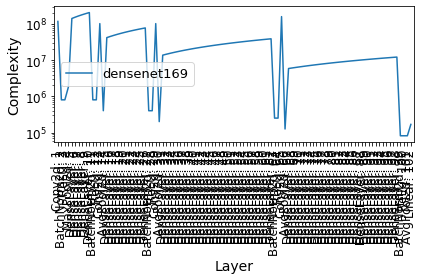

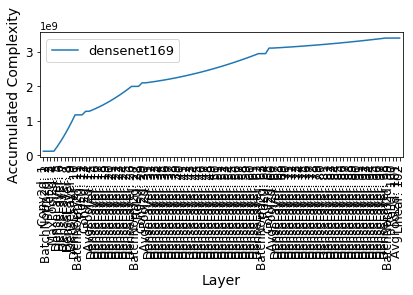

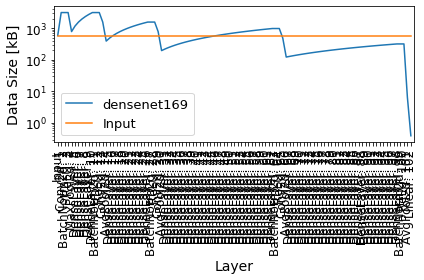

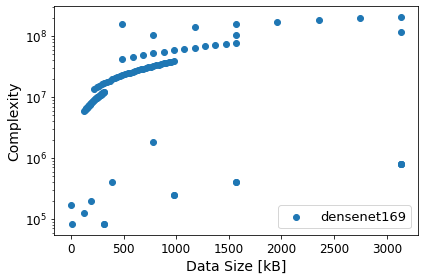

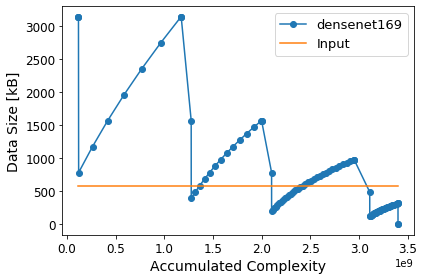

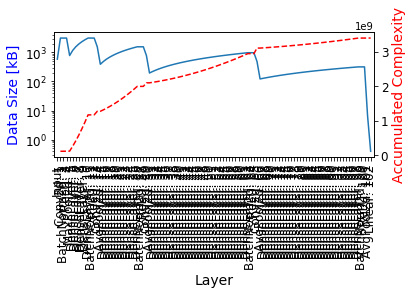

In [10]:
op_counts, data_sizes, accum_complexities = net_measure_util.compute_model_complexity_and_data_size(model, config['model']['type'], input_shape, scaled=False)

Number of Operations: 2101.67194M


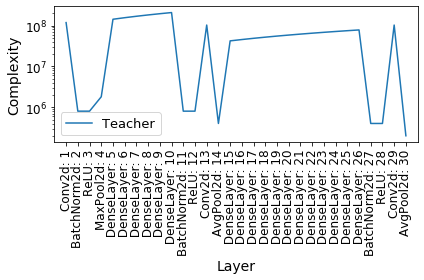

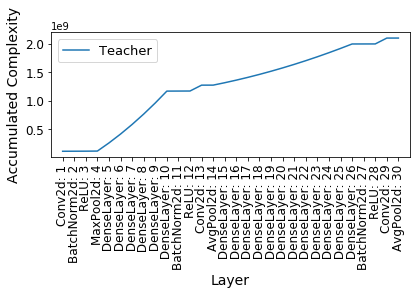

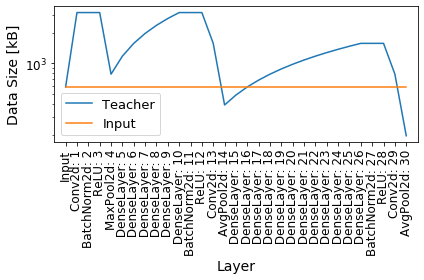

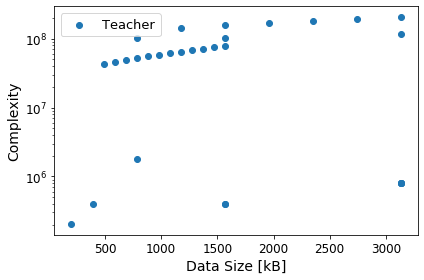

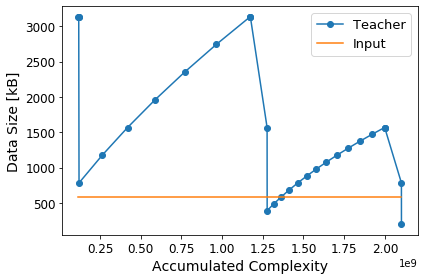

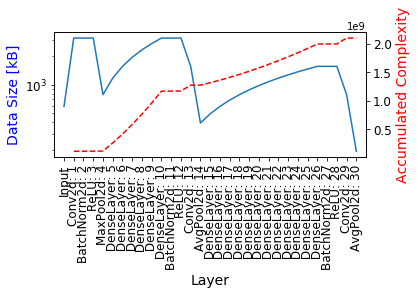

In [11]:
teacher_op_counts, teacher_data_sizes, teacher_accum_complexities = net_measure_util.compute_model_complexity_and_data_size(teacher_model, 'Teacher', input_shape, scaled=False)

Number of Operations: 1126.47621M


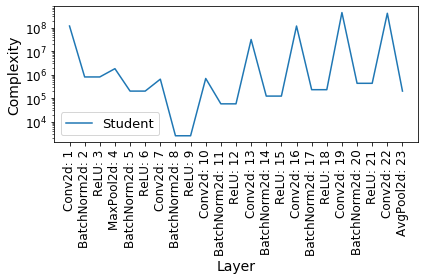

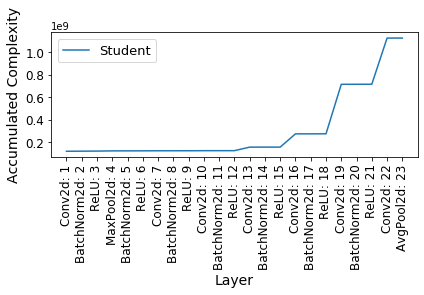

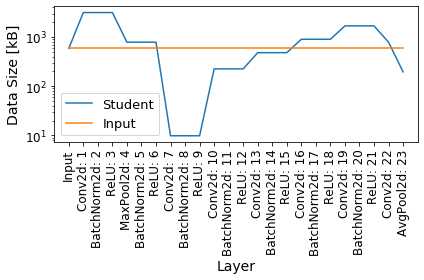

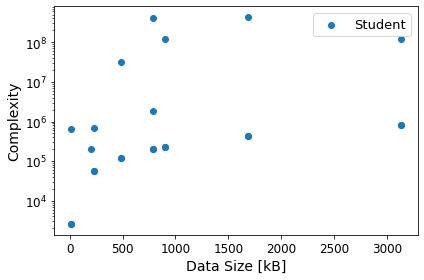

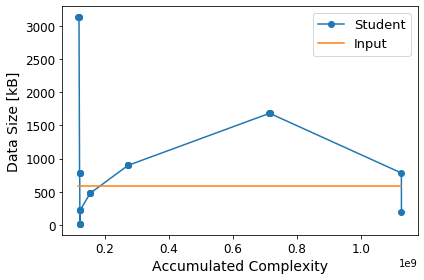

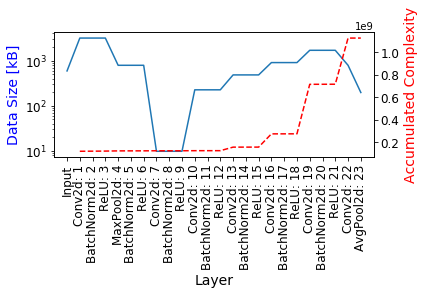

In [12]:
student_op_counts, student_data_sizes, student_accum_complexities = net_measure_util.compute_model_complexity_and_data_size(student_model, 'Student', input_shape, scaled=False)

In [13]:
def plot_multiple_models(models, model_types, input_shape):
    op_counts_list = list()
    data_sizes_list = list()
    accum_complexities_list = list()
    model_type_list = list()
    for model, model_type in zip(models, model_types):
        op_counts, data_sizes, accum_complexities = net_measure_util.compute_model_complexity_and_data_size(model, model_types, input_shape, scaled=False, plot=False)
        op_counts_list.append(op_counts)
        data_sizes_list.append(data_sizes)
        accum_complexities_list.append(accum_complexities)
        model_type_list.append(model_type)

    net_measure_util.plot_model_complexities(op_counts_list, model_type_list)
    net_measure_util.plot_accumulated_model_complexities(accum_complexities_list, model_type_list)
    net_measure_util.plot_model_data_sizes(data_sizes_list, False, model_type_list)
    

def show_components(model, model_type):
    modules = list()
    _ = module_util.extract_all_child_modules(model, modules)
    component_dict = dict()
    for module in modules:
        module_name = type(module).__name__
        if module_name not in component_dict:
            component_dict[module_name] = 0
        component_dict[module_name] += 1
    
    print('Model type: {}'.format(model_type))
    print('# params: {}'.format(module_util.count_params(model)))
    for module_name in component_dict.keys():
        print('{}:\t{}'.format(module_name, component_dict[module_name]))
    print()

def compare_models(teacher_model, student_model, model_types, input_shape, org_model_name=None, partition_idx=None):
    if org_model_name is not None:
        print('Original model: {}'.format(org_model_name))
    
    show_components(teacher_model, model_types[0])
    show_components(student_model, model_types[1])
    plot_multiple_models([teacher_model, student_model], model_types, input_shape)
    teacher_op_counts, teacher_data_sizes, teacher_accum_complexities = net_measure_util.compute_model_complexity_and_data_size(teacher_model, 'Teacher', input_shape, scaled=False, plot=False)
    student_op_counts, student_data_sizes, student_accum_complexities = net_measure_util.compute_model_complexity_and_data_size(student_model, 'Student', input_shape, scaled=False, plot=False)
    if partition_idx is None:
        partition_idx = np.argmin(student_data_sizes)
        accum_idx = partition_idx - 1
    elif partition_idx < 0:
        accum_idx = partition_idx
    else:
        accum_idx = partition_idx - 1
        
    print('Partition index: {}'.format(partition_idx))
    print('Sensor-side complexity: {:e}'.format(student_accum_complexities[accum_idx]))
    print('Complexity reduction: {:.2f}%'.format((1 - student_accum_complexities[accum_idx] / teacher_accum_complexities[-1]) * 100))
    print('Data Size: {:.2f}%'.format((student_data_sizes[partition_idx] / student_data_sizes[0]) * 100))

Model type: Teacher
# params: 1429632
Conv2d:	39
BatchNorm2d:	39
ReLU:	39
MaxPool2d:	1
AvgPool2d:	2

Model type: Student
# params: 1225542
Conv2d:	7
BatchNorm2d:	7
ReLU:	7
MaxPool2d:	1
AvgPool2d:	1



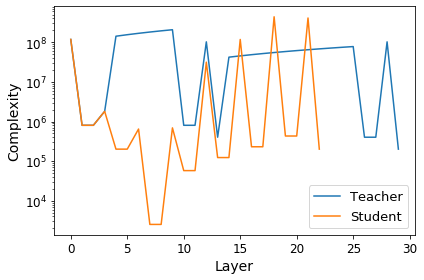

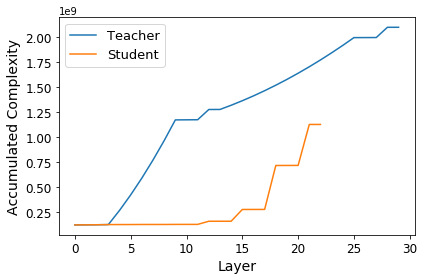

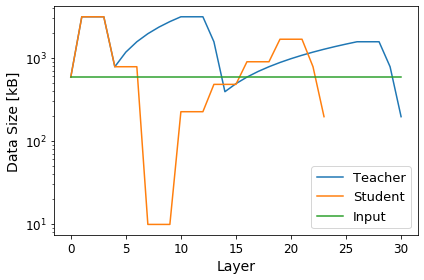

Partition index: 7
Sensor-side complexity: 1.224732e+08
Complexity reduction: 94.17%
Data Size: 1.68%


In [14]:
models = [teacher_model, student_model]
model_types = ['Teacher', 'Student']
compare_models(teacher_model, student_model, model_types, input_shape)

In [15]:
def get_teacher_and_student_models(mimic_config_file_path):
    mimic_config = yaml_util.load_yaml_file(mimic_config_file_path)
    input_shape = mimic_config['input_shape']
    teacher_model_config = mimic_config['teacher_model']
    teacher_model_config['config'] = '.' + teacher_model_config['config']
    teacher_model, teacher_model_type = mimic_util.get_teacher_model(teacher_model_config, input_shape, torch.device('cpu'))
    student_model = mimic_util.get_student_model(teacher_model_type, mimic_config['student_model'])
    return teacher_model_type, teacher_model, student_model, input_shape

In [16]:
def compare_student_to_teacher(mimic_config_file_path, partition_idx=-1):
    teacher_model_type, teacher_model, student_model, input_shape = get_teacher_and_student_models(mimic_config_file_path)
    models = [teacher_model, student_model]
    model_types = ['Teacher', 'Student']
    compare_models(teacher_model, student_model, model_types, input_shape, org_model_name=teacher_model_type, partition_idx=partition_idx)

Teacher checkpoint was not found at ./resource/ckpt/caltech101-densenet169.ckpt
Original model: densenet169
Model type: Teacher
# params: 1429632
Conv2d:	39
BatchNorm2d:	39
ReLU:	39
MaxPool2d:	1
AvgPool2d:	2

Model type: Student
# params: 1225542
Conv2d:	7
BatchNorm2d:	7
ReLU:	7
MaxPool2d:	1
AvgPool2d:	1



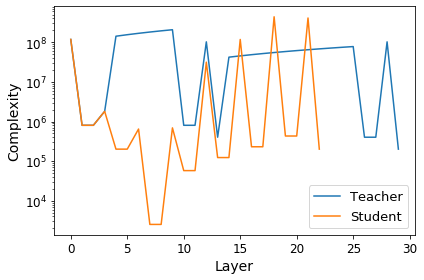

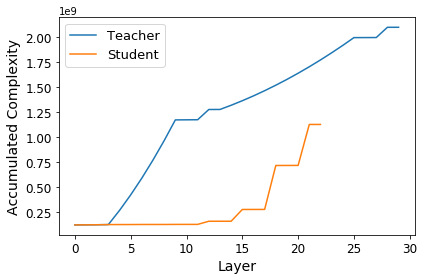

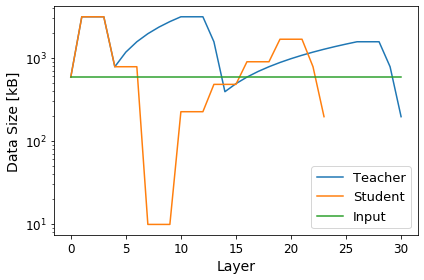

Partition index: 7
Sensor-side complexity: 1.224732e+08
Complexity reduction: 94.17%
Data Size: 1.68%


In [17]:
mimic_config_file_path = '../config/mimic/densenet169_head_mimic.yaml'
compare_student_to_teacher(mimic_config_file_path, partition_idx=None)